In [1]:
import numpy as np
import pandas as pd
import datetime
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb

import sys, os, gc, types
import time
from subprocess import check_output

import sklearn
from sklearn.model_selection import train_test_split

In [2]:
root_paths = [
    "/data/kaggle-wikipedia/data/",
    "/Users/jiayou/Dropbox/JuanCode/Kaggle/Wikipedia/data/",
    "/Users/jiayou/Dropbox/Documents/JuanCode/Kaggle/Wikipedia/data/"
]
root = None
for p in root_paths:
    if os.path.exists(p):
        root = p
        break
print(check_output(["ls", root]).decode("utf8"))

date_df.csv
key_1.csv
median_49.csv
page_df.csv
page_ohe.csv
sample_submission_1.csv
spider.txt
train_1.csv



In [3]:
train = pd.read_csv(root + 'train_1.csv')
train.fillna(0, inplace = True)
date_df = pd.read_csv(root + 'date_df.csv')
page_df = pd.read_csv(root + 'page_ohe.csv')
median_49 = pd.read_csv(root + 'median_49.csv')

In [4]:
train_df = train.melt(id_vars=['Page'], var_name='date')

# construct ABT

In [5]:
train_df = train_df.merge(page_df, how='left', on='Page')
train_df = train_df.merge(date_df.drop('date_str', axis = 1), how='left', on='date')

In [6]:
val_days = 62
for i in range(-val_days, 0):
    median_49.iloc[:, i] = median_49.iloc[:, -val_days-1].reshape((len(median_49),1))

/Users/jiayou/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


In [7]:
median_df = median_49.melt(id_vars=['Page'], var_name='date')
median_df.rename(columns={'value':'median'}, inplace = True)
train_df = train_df.merge(median_df, how='left', on=['Page','date'])

In [8]:
train_df['isval'] = (train_df.dayofyear > 366 - val_days) & (train_df.year == 2016)

In [9]:
train_df.head()

,Page,date,value,domain_commons.wikimedia.org,domain_de.wikipedia.org,domain_en.wikipedia.org,domain_es.wikipedia.org,domain_fr.wikipedia.org,domain_ja.wikipedia.org,domain_ru.wikipedia.org,domain_www.mediawiki.org,domain_zh.wikipedia.org,access_all-access,access_desktop,access_mobile-web,agent_all-agents,agent_spider,dayofweek,dayofmonth,dayofyear,month,year,isweekday,median,isval
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2,1,182,7,2015,True,18.0,False
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2,1,182,7,2015,True,11.0,False
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2,1,182,7,2015,True,1.0,False
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2,1,182,7,2015,True,35.0,False
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,2015-07-01,0.0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2,1,182,7,2015,True,0.0,False


In [10]:
for c, dtype in zip(train_df.columns, train_df.dtypes):
    if dtype == np.float64:
        train_df[c] = train_df[c].astype(np.float32)
    if dtype == np.int64:
        train_df[c] = train_df[c].astype(np.int32)

In [11]:
del median_df, page_df, date_df, train
gc.collect()

240

# Preparing data and hyperparams

In [13]:
name = 'v0-r0'
down_sample = None
num_searches = 1
boosting_rounds = 10000
stopping_rounds = 10
down_sample = 1000

In [14]:
if down_sample is not None:
    train_df = train_df[train_df.index % down_sample == 0]

In [24]:
train_df.head()

,Page,date,value,domain_commons.wikimedia.org,domain_de.wikipedia.org,domain_en.wikipedia.org,domain_es.wikipedia.org,domain_fr.wikipedia.org,domain_ja.wikipedia.org,domain_ru.wikipedia.org,domain_www.mediawiki.org,domain_zh.wikipedia.org,access_all-access,access_desktop,access_mobile-web,agent_all-agents,agent_spider,dayofweek,dayofmonth,dayofyear,month,year,isweekday,median,isval,value_log,median_log
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2,1,182,7,2015,True,18.0,False,2.944439,2.944439
1000,大魯閣草衙道_zh.wikipedia.org_all-access_spider,2015-07-01,1.0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2,1,182,7,2015,True,1.0,False,0.693147,0.693147
2000,鄭恩地_zh.wikipedia.org_all-access_spider,2015-07-01,8.0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2,1,182,7,2015,True,8.0,False,2.197225,2.197225
3000,陳嘉寶_zh.wikipedia.org_all-access_spider,2015-07-01,2.0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2,1,182,7,2015,True,2.0,False,1.098612,1.098612
4000,輔大心理系性侵事件_zh.wikipedia.org_all-access_spider,2015-07-01,0.0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2,1,182,7,2015,True,0.0,False,0.000000,0.000000


In [23]:
train_df['value_log'] = np.log1p(train_df['value'])
train_df['median_log'] = np.log1p(train_df['median'])

In [25]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l1'},
    'num_leaves': 128,
#     'min_sum_hessian_in_leaf': 20,
    'max_depth': 12,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.85,
    'bagging_freq': 3,
    'verbose': 1,
#     'device' : 'gpu'
}

In [26]:
train = train_df[train_df.isval == False]
val = train_df[train_df.isval == True]

In [27]:
drop_list = ['value', 'isval', 'Page', 'date', 'value_log', 'median']

lgb_train = lgb.Dataset(
    train.drop(drop_list, axis = 1), 
    train.value_log,
)
lgb_eval = lgb.Dataset(
    val.drop(drop_list, axis = 1), 
    val.value_log, 
    reference=lgb_train,
)

gc.collect()

566

In [28]:
# self-defined eval metric
# f(preds: array, train_data: Dataset) -> name: string, value: array, is_higher_better: bool
# binary error
def SMAPE(preds, train_data):
    labels = train_data.get_label()
    y_true = np.expm1(labels)
    y_pred = np.expm1(preds)
    loss = np.mean(np.abs(y_true - y_pred) / np.maximum(1e-6, (np.abs(y_true) + np.abs(y_pred)))) * 200
    return 'SMAPE', loss, False

Start LightGBM training...
[1]	training's l1: 2.02618	training's SMAPE: 133.064	valid_1's l1: 1.88961	valid_1's SMAPE: 128.181
Training until validation scores don't improve for 10 rounds.
[2]	training's l1: 1.9309	training's SMAPE: 130.226	valid_1's l1: 1.80466	valid_1's SMAPE: 125.208
[3]	training's l1: 1.88603	training's SMAPE: 128.501	valid_1's l1: 1.75533	valid_1's SMAPE: 123.17
[4]	training's l1: 1.79813	training's SMAPE: 125.637	valid_1's l1: 1.67647	valid_1's SMAPE: 120.207
[5]	training's l1: 1.77865	training's SMAPE: 124.953	valid_1's l1: 1.65473	valid_1's SMAPE: 119.353
[6]	training's l1: 1.6964	training's SMAPE: 122.077	valid_1's l1: 1.58107	valid_1's SMAPE: 116.377
[7]	training's l1: 1.66061	training's SMAPE: 120.471	valid_1's l1: 1.54221	valid_1's SMAPE: 114.516
[8]	training's l1: 1.62757	training's SMAPE: 118.936	valid_1's l1: 1.5062	valid_1's SMAPE: 112.739
[9]	training's l1: 1.55349	training's SMAPE: 116.096	valid_1's l1: 1.44146	valid_1's SMAPE: 109.855
[10]	training's

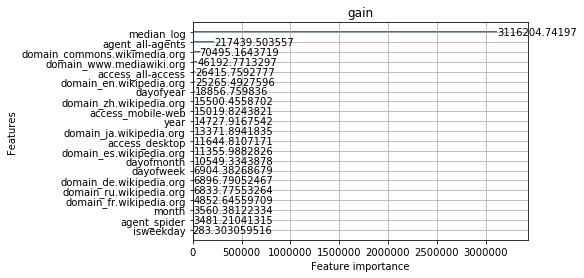

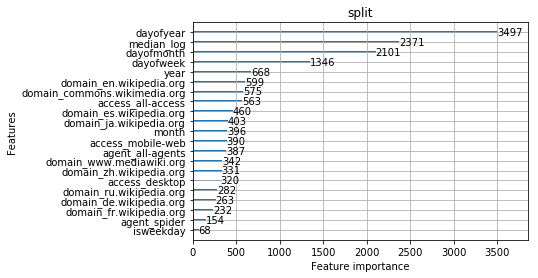

In [35]:
results = []
for i in range(num_searches):
    print('Start LightGBM training...')
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=boosting_rounds,
                    feval=SMAPE,
                    valid_sets=[lgb_train, lgb_eval],
#                   categorical_feature=[],
                    early_stopping_rounds=stopping_rounds)

    print('Save model...')
    # save model to file
    gbm.save_model('model.{}.txt'.format(name))

    print('Plot feature importances...') 
    ax = lgb.plot_importance(gbm, max_num_features=100, importance_type='gain', title = 'gain')
    plt.show()
    ax = lgb.plot_importance(gbm, max_num_features=100, importance_type='split', title = 'split')
    plt.show()

- https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/36780
- https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/38274#215155